# <center>Assignment</center>

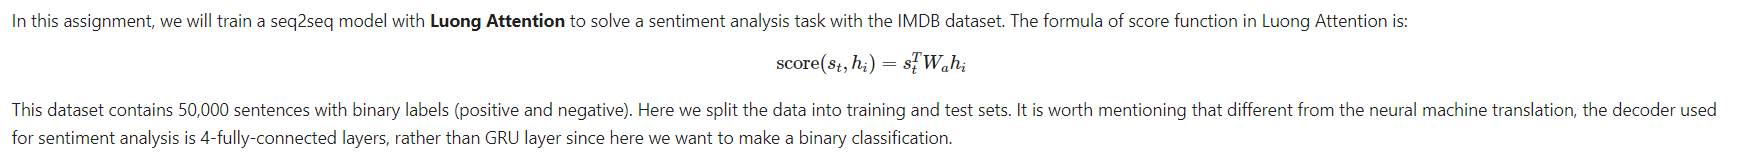

In [1]:
import tensorflow as tf
import pandas as pd
import re
import numpy as np
import os
import time
from sklearn.model_selection import train_test_split

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# load the dataset
movie_reviews = pd.read_csv("./data/IMDB Dataset.csv")

### Data preprocessing

In [4]:
# check if there is any null value in the dataset
movie_reviews.isnull().values.any()

False

In [5]:
# show the size of the dataset
movie_reviews.shape

(50000, 2)

In [6]:
# show the first five data in the dataset
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
movie_reviews["review"][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [8]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [9]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

# replace the positive with 1, replace the negative with 0
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x == "positive" else 0, y)))

In [10]:
# Split the training dataset and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("# training data: {:d}\n# test data: {:d}".format(len(X_train), len(X_test)))

# training data: 40000
# test data: 10000


In [11]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

max_len = 100
# padding sentences to the same length
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=max_len)

In [12]:
# show the preprocessed data
X_train[0]

array([   1,  296,  140, 2854,    2,  405,  614,    1,  263,    5, 3514,
        977,    4,   25,   37,   11, 1237,  215,   62,    2,   35,    5,
         27,  217,   24,  189, 1430,    7, 1068,   15, 4868,   81,    1,
        221,   63,  351,   64,   52,   24,    4, 3547,   13,    6,   19,
        192,    4, 8148,  859, 3430, 1720,   17,   23,    4,  158,  194,
        175,  106,    9, 1604,  461,   71,  218,    4,  321,    2, 3431,
         31,   20,   47,   68, 1844, 4668,   11,    6, 1365,    8,   16,
          5, 3475, 1990,   14,   59,    1, 2380,  460,  518,    2,  170,
       2524, 2698, 1745,    4,  573,    6,   33,    1, 3750,  198,  345,
       3812])

In [13]:
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 128
steps_per_epoch = len(X_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
# only reserve 10000 words
vocab_size = 10000

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=False)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 100]), TensorShape([128]))

In [14]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        # vacab_size=10000, embedding_dim=256 enc_units=1024 batch_sz=64
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_activation='sigmoid',
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        # x is the training data with shape == (batch_size，max_length)  -> (128, 100)
        # which means there are batch_size sentences in one batch, the length of each sentence is max_length
        # hidden state shape == (batch_size, units) -> (128, 1024)
        # after embedding, x shape == (batch_size, max_length, embedding_dim) -> (128, 100, 256)
        x = self.embedding(x)
        
        # output contains the state(in GRU, the hidden state and the output are same) from all timestamps,
        # output shape == (batch_size, max_length, units) -> (128, 100, 1024)
        # state is the hidden state of the last timestamp, shape == (batch_size, units) -> (128, 1024)
        output, state = self.gru(x, initial_state=hidden)
        
        return output, state

    def initialize_hidden_state(self):
        # initialize the first state of the gru,  shape == (batch_size, units) -> (128, 1024)
        return tf.zeros((self.batch_sz, self.enc_units))

In [15]:
encoder = Encoder(vocab_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))
# the output and the hidden state of GRU is equal
print(sample_output[-1, -1, :] == sample_hidden[-1, :])

Encoder output shape: (batch size, sequence length, units) (128, 100, 1024)
Encoder Hidden state shape: (batch size, units) (128, 1024)
tf.Tensor([ True  True  True ...  True  True  True], shape=(1024,), dtype=bool)


In [19]:
class LuongAttention(tf.keras.Model):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        # TODO: Complete the function.
        self.W = tf.keras.layers.Dense(units)

    def call(self, query, values):
        # TODO: Implement the Luong attention.
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score = tf.matmul(self.W(values),
                         tf.transpose(hidden_with_time_axis, perm=[0, 2, 1]))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [20]:
class Decoder(tf.keras.Model):
    def __init__(self, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        
        # pass through four fully connected layers, the model will return 
        # the probability of the positivity of the sentence
        self.fc_1 = tf.keras.layers.Dense(2048)
        self.fc_2 = tf.keras.layers.Dense(512)
        self.fc_3 = tf.keras.layers.Dense(64)
        self.fc_4 = tf.keras.layers.Dense(1)

        # used for attention
        self.attention = LuongAttention(self.dec_units)

    def call(self, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        output = self.fc_1(context_vector)
        output = self.fc_2(output)
        output = self.fc_3(output)
        output = self.fc_4(output)

        return output, attention_weights

In [21]:
decoder = Decoder(units, BATCH_SIZE)
sample_decoder_output, _ = decoder(sample_hidden, sample_output)
print('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (128, 1)


In [22]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def loss_function(real, pred):
    loss_ = loss_object(real, pred)
    return tf.reduce_mean(loss_)

In [23]:
checkpoint_dir = './checkpoints/sentiment-analysis'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [24]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        # passing enc_output to the decoder
        predictions, _ = decoder(enc_hidden, enc_output)

        loss = loss_function(targ, predictions)

    # collect all trainable variables
    variables = encoder.trainable_variables + decoder.trainable_variables

    # calculate the gradients for the whole variables
    gradients = tape.gradient(loss, variables)

    # apply the gradients on the variables
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

In [25]:
# set the epochs for training
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    # get the initial hidden state of gru
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))

    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.6934
Epoch 1 Batch 100 Loss 0.3524
Epoch 1 Batch 200 Loss 0.3659
Epoch 1 Batch 300 Loss 0.3284
Epoch 1 Loss 0.3818
Time taken for 1 epoch 22.970287561416626 sec

Epoch 2 Batch 0 Loss 0.2491
Epoch 2 Batch 100 Loss 0.3127
Epoch 2 Batch 200 Loss 0.1893
Epoch 2 Batch 300 Loss 0.2209
Epoch 2 Loss 0.2546
Time taken for 1 epoch 21.394280195236206 sec

Epoch 3 Batch 0 Loss 0.1850
Epoch 3 Batch 100 Loss 0.2146
Epoch 3 Batch 200 Loss 0.1741
Epoch 3 Batch 300 Loss 0.2343
Epoch 3 Loss 0.1853
Time taken for 1 epoch 21.161839246749878 sec

Epoch 4 Batch 0 Loss 0.1378
Epoch 4 Batch 100 Loss 0.1714
Epoch 4 Batch 200 Loss 0.1574
Epoch 4 Batch 300 Loss 0.1796
Epoch 4 Loss 0.1228
Time taken for 1 epoch 21.41292381286621 sec

Epoch 5 Batch 0 Loss 0.1012
Epoch 5 Batch 100 Loss 0.0569
Epoch 5 Batch 200 Loss 0.1552
Epoch 5 Batch 300 Loss 0.0843
Epoch 5 Loss 0.0803
Time taken for 1 epoch 21.1884982585907 sec

Epoch 6 Batch 0 Loss 0.0188
Epoch 6 Batch 100 Loss 0.0388
Epoch 6 Batch 200 Lo

In [26]:
print(tf.train.latest_checkpoint(checkpoint_dir))
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

./checkpoints/sentiment-analysis\ckpt-5


In [27]:
@tf.function
def test_step(inp, enc_hidden):
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        predictions, attention_weights = decoder(enc_hidden, enc_output)
    return predictions, attention_weights

In [28]:
def evaluate(test_data):
    enc_hidden = encoder.initialize_hidden_state()
    
    for batch, (inp, targ) in enumerate(test_data):
        if len(inp) != BATCH_SIZE:
            enc_hidden = tf.zeros((len(inp), units))
        # make prediction
        if batch == 0:
            predictions, attention_weights = test_step(inp, enc_hidden)
            predictions, attention_weights = predictions.numpy(), attention_weights.numpy()
        else:
            _predictions, _attention_weights = test_step(inp, enc_hidden)
            _predictions, _attention_weights = _predictions.numpy(), _attention_weights.numpy()
            predictions = np.concatenate((predictions, _predictions))
            attention_weights = np.concatenate((attention_weights, _attention_weights))
    
    predictions = np.squeeze(predictions)
    attention_weights = np.squeeze(attention_weights)
    predictions[np.where(predictions < 0.5)] = 0
    predictions[np.where(predictions >= 0.5)] = 1
    return predictions, attention_weights

In [29]:
y_pred, attention_weights = evaluate(test_dataset)

In [30]:
print('Accuracy: ', (y_pred == y_test).sum() / len(y_test))

Accuracy:  0.8498


In [31]:
from termcolor import colored
for idx, data in enumerate(X_test[:10]):
    print('y_true: {:d}'.format(y_test[idx]))
    print('y_predict: {:.0f}'.format(y_pred[idx]))
    
    # get the twenty most largest attention weights
    large_weights_idx = np.argsort(attention_weights[idx])[::-1][:10]
    
    for _idx in range(len(data)):
        word_idx = data[_idx]
        if word_idx != 0:
            if _idx in large_weights_idx:
                print(colored(tokenizer.index_word[word_idx], 'red'), end=' ')
                # try this if termcolor is not working properly
                # print(f'\033[31m{tokenizer.index_word[word_idx]}\033[0m', end=' ')
            else:
                print(tokenizer.index_word[word_idx], end=' ')
    print("\n\n")

y_true: 1
y_predict: 0
changed it was terrible main event just like every match is in is terrible other matches on the card were razor ramon vs ted brothers vs bodies shawn michaels vs this was the event where shawn named his big monster of body guard vs kid hart first takes on then takes on jerry and stuff with the and was always very interesting then destroyed marty undertaker took on giant in another terrible match the smoking and took on bam bam and the and the world title against lex this match was boring and it has terrible ending however it deserves 


y_true: 1
y_predict: 1
of subject matter as are and broken in many ways on many many issues happened to see the pilot premiere in passing and just had to keep in after that to see if would ever get the girl after seeing them all on television was delighted to see them available on dvd have to admit that it was the only thing that kept me sane whilst had to do hour night shift and developed insomnia farscape was the only thing to g